In [1]:
from matplotlib import pyplot as plt
import multigrate as mtg
import scanpy as sc

Global seed set to 0
Global seed set to 0


In [2]:
%load_ext autoreload
%autoreload 2

# Load data

In [3]:
# load preprocessed data separately for RNA and ADT modalities from a CITE-seq experiment
rna = sc.read('../data/10x/expressions_hvg.h5ad')
atac = sc.read('../data/10x/peaks.h5ad')

In [23]:
atac1 = atac[:500].copy()
atac2 = atac[500:750].copy()

In [5]:
# follow scvi-tools pipeline and register needed data that later will be used in the network
mtg.model.MultiVAE.setup_anndata(
    adatas = [[rna], [atac]],   # list per modality
    groups = [[0], [0]],          # how data is paired
    layers = [['count'], [None]]) # which layers to use

INFO     Using batches from adata.obs["batch_key"]                                           
INFO     Using batches from adata.obs["batch_key"]                                           
INFO     No label_key inputted, assuming all cells have same label                           
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["count"]                                               
INFO     Using data from adata.layers["count"]                                               
INFO     Successfully registered anndata object containing 10000 cells, 4000 vars, 1 batches,
         1 labels, and 0 proteins. Also registered 2 extra categorical covariates and 1 extra
         continuous covariates.                                                              
INFO     Successfully registered anndata object containing 10000 cells, 4000 vars, 1 batches,
         1 labels, and 0 proteins. Also registered 2 extra c

In [6]:
model = mtg.model.MultiVAE(
    adatas = [[rna], [atac]],   # same as above
    condition = True,           # whether to do batch correction (not important here as just 1 batch)
    losses = ['nb', 'mse'])     # losses for the decoder: if using raw counts, use NB or ZINB

[0, 0]
1
[0, 0]
1


In [9]:
model.train(n_iters=5000, kl_coef=1e-6)

 |████████████████████| 100.0% iter=5000/5000, time=56.98(s), loss=0.2236, recon=0.2235, kl=34.7377, integ=0.0000, cycle=0.0000, val_loss=0.2190, val_recon=0.2189, val_kl=31.8832, val_integ=0.0000, val_cycle=0.0000

In [10]:
model.history

,iteration,train_loss,train_recon,train_recon_mse,train_recon_nb,train_recon_zinb,train_recon_bce,train_kl,train_integ,train_cycle,val_loss,val_recon,val_recon_mse,val_recon_nb,val_kl,val_integ,val_cycle
0,500,0.290304,0.290300,0.064501,0.225799,0.0,0.0,15.882805,0.0,0.0,0.249805,0.249787,0.052388,0.197399,18.706722,0,0
1,1000,0.250193,0.250182,0.054866,0.195317,0.0,0.0,21.827753,0.0,0.0,0.243196,0.243175,0.051974,0.191200,21.463867,0,0
2,1500,0.240304,0.240289,0.052381,0.187908,0.0,0.0,19.309465,0.0,0.0,0.234043,0.234027,0.051883,0.182143,16.180796,0,0
3,2000,0.232014,0.231993,0.053027,0.178966,0.0,0.0,21.202390,0.0,0.0,0.229149,0.229128,0.051808,0.177320,21.187313,0,0
4,2500,0.229005,0.228981,0.052159,0.176822,0.0,0.0,23.512513,0.0,0.0,0.227730,0.227708,0.051377,0.176332,21.829874,0,0
5,3000,0.227182,0.227156,0.051124,0.176032,0.0,0.0,25.903696,0.0,0.0,0.225371,0.225346,0.050413,0.174933,24.808117,0,0
6,3500,0.225660,0.225632,0.050338,0.175293,0.0,0.0,28.839157,0.0,0.0,0.222835,0.222809,0.050262,0.172548,26.251198,0,0
7,4000,0.227762,0.227731,0.051296,0.176434,0.0,0.0,30.908858,0.0,0.0,0.220782,0.220754,0.050216,0.170538,28.684805,0,0
8,4500,0.223572,0.223538,0.050013,0.173525,0.0,0.0,33.666444,0.0,0.0,0.219826,0.219795,0.050240,0.169556,30.649408,0,0
9,4999,0.223576,0.223541,0.050622,0.172919,0.0,0.0,34.737740,0.0,0.0,0.218973,0.218941,0.050155,0.168786,31.883186,0,0


,iteration,train_loss,train_recon,train_recon_mse,train_recon_nb,train_recon_zinb,train_recon_bce,train_kl,train_integ,train_cycle,val_loss,val_recon,val_recon_mse,val_recon_nb,val_kl,val_integ,val_cycle
0,500,0.290304,0.290300,0.064501,0.225799,0.0,0.0,15.882805,0.0,0.0,0.249805,0.249787,0.052388,0.197399,18.706722,0,0
1,1000,0.250193,0.250182,0.054866,0.195317,0.0,0.0,21.827753,0.0,0.0,0.243196,0.243175,0.051974,0.191200,21.463867,0,0
2,1500,0.240304,0.240289,0.052381,0.187908,0.0,0.0,19.309465,0.0,0.0,0.234043,0.234027,0.051883,0.182143,16.180796,0,0
3,2000,0.232014,0.231993,0.053027,0.178966,0.0,0.0,21.202390,0.0,0.0,0.229149,0.229128,0.051808,0.177320,21.187313,0,0
4,2500,0.229005,0.228981,0.052159,0.176822,0.0,0.0,23.512513,0.0,0.0,0.227730,0.227708,0.051377,0.176332,21.829874,0,0
5,3000,0.227182,0.227156,0.051124,0.176032,0.0,0.0,25.903696,0.0,0.0,0.225371,0.225346,0.050413,0.174933,24.808117,0,0
6,3500,0.225660,0.225632,0.050338,0.175293,0.0,0.0,28.839157,0.0,0.0,0.222835,0.222809,0.050262,0.172548,26.251198,0,0
7,4000,0.227762,0.227731,0.051296,0.176434,0.0,0.0,30.908858,0.0,0.0,0.220782,0.220754,0.050216,0.170538,28.684805,0,0
8,4500,0.223572,0.223538,0.050013,0.173525,0.0,0.0,33.666444,0.0,0.0,0.219826,0.219795,0.050240,0.169556,30.649408,0,0
9,4999,0.223576,0.223541,0.050622,0.172919,0.0,0.0,34.737740,0.0,0.0,0.218973,0.218941,0.050155,0.168786,31.883186,0,0


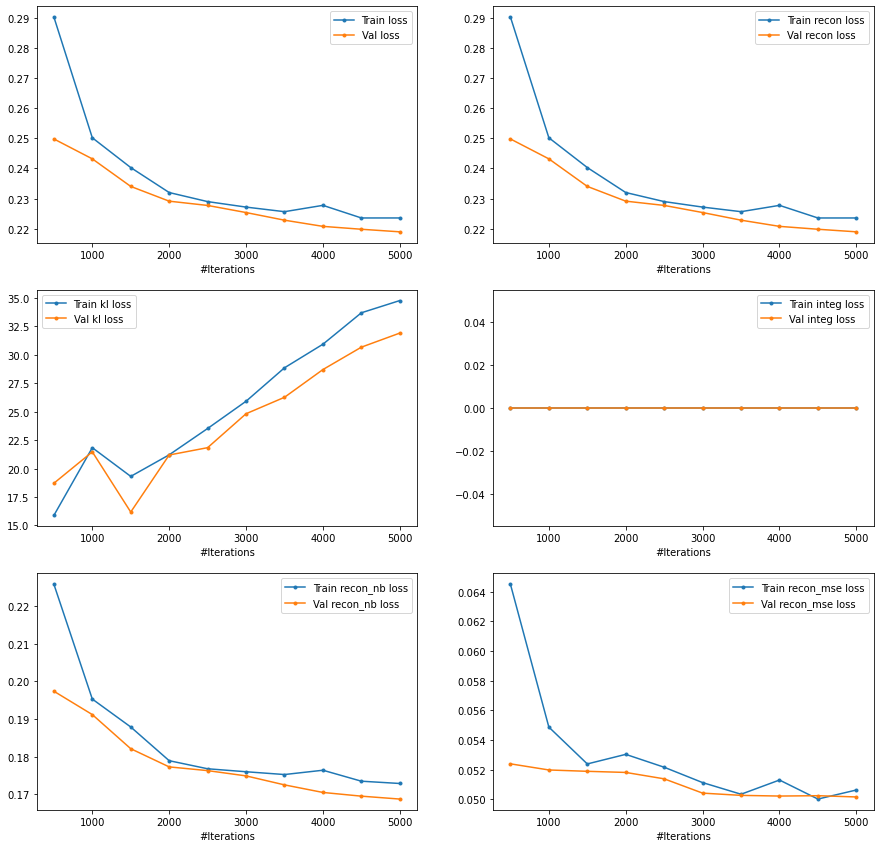

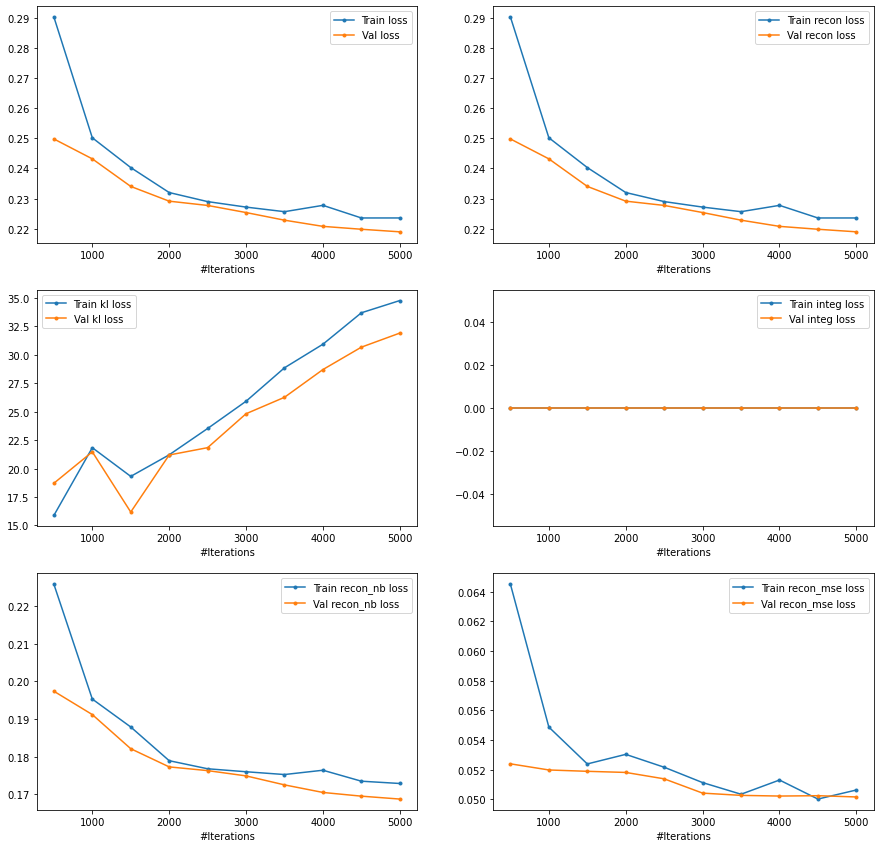

In [11]:
plt.figure(figsize=(15, 20));
loss_names = ['recon', 'kl', 'integ', 'recon_nb', 'recon_mse'] # recon_mse
nrows = 4

plt.subplot(nrows, 2, 1)
plt.plot(model.history['iteration'], model.history['train_loss'], '.-', label='Train loss');
plt.plot(model.history['iteration'], model.history['val_loss'], '.-', label='Val loss');
plt.xlabel('#Iterations');
plt.legend()

for i, name in enumerate(loss_names):
    plt.subplot(nrows, 2, i+2)
    plt.plot(model.history['iteration'], model.history[f'train_{name}'], '.-', label=f'Train {name} loss');
    plt.plot(model.history['iteration'], model.history[f'val_{name}'], '.-', label=f'Val {name} loss');
    plt.xlabel('#Iterations');
    plt.legend()

In [14]:
model.get_latent_representation()

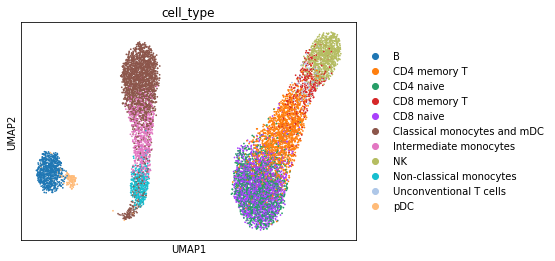

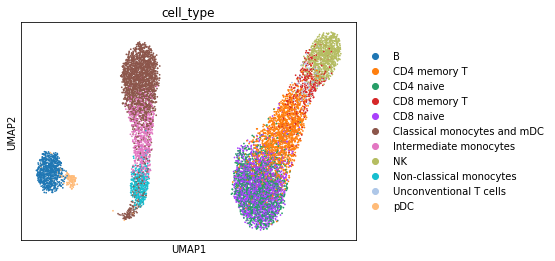

In [15]:
sc.pp.neighbors(rna, use_rep="latent")
sc.tl.umap(rna)
sc.pl.umap(rna, color='cell_type')